In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'quickdraw-doodle-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F10200%2F868375%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240607%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240607T145853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D61aeda184e809cc50d0314c1d8c2c6952b68ad127a7a92691720bd01267af1ad9b97e710fb5344d269c47a1cf21d9a294e69acff926a5977875db4e38da6198f38be18f2fac6e1f3bb6998d7f573efce4e9d02c3009cad88377c70f05e4947063a9fd9a72c08a7f68150d2c809f4220da2c049e466794354c7dc15bf6dda41604aed919c7a960ea9870f65451d02e97b20117d8ab06bc1796c4e09c2bec8a4b73ba76a62878f8b386d3d2bef741d7c2dfb43a9ec72598e308eb46d616def68499f86309cda633d36ca90931e3ef9580b03f1f94b377e95150206686f077355354df1406a98332a487f0c79e7a1a3d4f65e857120bcea44b8ea617e08ee0b4e5f,mobilenetv3/keras/mobilenet_v3_large_imagenet/3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F4618%2F6116%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240607%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240607T145853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D27105f010a27e293ffb4cd598fcec8fa287364301de72cae3c5dd223011753d93c1532dbc32552469993363738715b081fcf8ca87edbfd4240e0acaedd8703251d26c71816affa2d19f33d83ef38ebed823e809753024215c57c9bd703d764989a4ddc73a9f0f745cc911d72f7ad36d196c18aa6a199636c92b7050f513e58f6b6bab161dd3928317a08beb24240dfc849cb892c544866ff54cedca4a73ecb7e8af2226c0801199935ad738a53c05eb8c926c7217970377465884723239899d3a47b456a211fca0aed142456890a429534b1ebbb83f5c8831adf94965443fe9197759f4499aa196c63e934901ce4809e94f524a497c8ad8148555657b85388c5,mobilenet/tensorflow2/gg/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F51759%2F61962%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240607%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240607T145853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9771c61205ae2d96ea85d913e7c385463955f7264551656754c3577035e5fee915acb90330026acf08d2623e947da1cea7b795cc1cc9738d1e99175b52b4f6c9df9ccc482201328ff7f877744fbfea28616e25b54a590f0a8a8c98fd804b54a39735b4fd07621e9171d31b77f2e7485dbd5c1c2b97f3e4a71d00cc8652cbb7a2e3cf7fd2f9486c5489f8b380b27281b5ba8849b6decb346f13f1b7106f26f6194d6e4e8b77019ff3c74a2c168f46fe9d46073d925999ab89b69e31a5503e0869196e7ccf98b0f79edcd98798b4b524aef7bb5aee1584638afad6552f1f40cac5e02e2f726111008da4bf1cb332fd0927da313266d66012af3336124fbf1e3798,yolov8/keras/yolo_v8_l_backbone_coco/2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F4651%2F6108%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240607%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240607T145853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2faf1601cb23d45ca5eea7c728de5f1faf4cf69852dd02ae500ad93a559c75c26eaa933fcd4b4462f6eea92de0b647e4946eb6834b3604f1d443b2e612351df0cc3417a56c90630d8de6c28582d79db9779db0a14a7bae2d2a78c704058ff43e17a7e653f383e3696b091b1fdccd766cdfc02af9f73126861da792cfdbe948dd556c6fe738697084a0d10e3802bb919784c3f5aa7010e63e702ae25b0be1c0bac1de4533a2a8ad1360a102a7a03792c9fab140db5338465778a74a5fea4d2eaeac0089be9f8d02d8dd2129b13a795408dab95c617a3c9c7f16a45731a41cbe7e0f694f80f2b93d4d0ff06b69f0c7674d3393d7876160873e60a5a547881c0213'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import cv2

import json
import datetime as dt
from tqdm import tqdm

import ast
import math
from glob import glob
import glob
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from multiprocessing.dummy import Pool
from keras.models import load_model
import time
import keras
import random

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import load_model

from skimage.draw import draw
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os


## Helper Functions for loading data

In [ ]:
INPUT_DIR = './input'

def read_training_csv(self, category, nrows=None, usecols=None, drawing_transform=False):
    df = pd.read_csv(os.path.join(self.input_path, 'train_simplified', category + '.csv'),
                     nrows=nrows, parse_dates=['timestamp'], usecols=usecols)
    if drawing_transform:
        df['drawing'] = df['drawing'].apply(json.loads)
    return df

def split_train_val():
    ALL_FILES = glob.glob('../input/shuffle-csvs/*.csv.gz')
    VALIDATION_FILE = '../input/shuffle-csvs/train_k'+str(int(random.random()*93))+'.csv.gz'
    ALL_FILES.remove(VALIDATION_FILE)
    np.random.seed(seed=2004)
    return ALL_FILES, VALIDATION_FILE

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir('/kaggle/input/quickdraw-doodle-recognition/train_simplified')
    return sorted([f2cat(f) for f in files], key=str.lower)


## Helper functions for MAP@3 and top 3 accuracy calculations

In [ ]:
def mapk(actual, predicted, k=3):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        apk = 0
    apk = score / min(len(actual), k)
    return np.mean(apk)

def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

## Constants and Hyperparameters

In [ ]:
AUGMENTATION = True
STEPS = 200
BATCH_SIZE = 100
EPOCHS = 10
NCATS = 340
LEARNING_RATE = 0.002
BASE_SIZE = 256

cats = list_all_categories()

IMG_SHAPE = (128,128,3)
IMG_SIZE = IMG_SHAPE[0]

## Image Encoding Function
Here, we encode the RGB channels such that R contains stroke points and G contains gradients. B is set to 255.

In [ ]:
def draw_cv2(raw_strokes, size=256, lw=6, augmentation = False):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        points_count = len(stroke[0]) - 1
        grad = 255//points_count
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), (255, 255 - min(t,10)*13, max(255 - grad*i, 20)), lw)
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
    if augmentation:
        if random.random() > 0.5:
            img = np.fliplr(img)
    return img

## Data Generator

In [ ]:
def generator(files, size, batchsize, lw=6, augmentation=False, mode = 'train', num_classes=None):
    while True:
        if mode == 'train':
            for filename in files:
                for df in pd.read_csv(filename, chunksize=batchsize):
                    df['drawing'] = df['drawing'].apply(eval)
                    x = np.zeros((len(df), size, size, 3))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        x[i] = draw_cv2(raw_strokes, size=size, lw=lw, augmentation=augmentation)
                    x = x / 255.
                    x = x.astype(np.float32)
                    y = to_categorical(df.y, num_classes=num_classes)
                    yield x, y
        else:
            df = files if isinstance(files, pd.DataFrame) else pd.concat(pd.read_csv(f) for f in files)
            df['drawing'] = df['drawing'].apply(eval)
            for i in range(0, len(df), batchsize):
                chunk = df[i:i+batchsize]
                x = np.zeros((len(chunk), size, size, 3))
                for j, raw_strokes in enumerate(chunk.drawing.values):
                    x[j] = draw_cv2(raw_strokes, size=size, lw=lw)
                x = x / 255.
                x = x.astype(np.float32)
                if mode == 'test':
                    yield x
                else:
                    y = to_categorical(chunk.y, num_classes=num_classes)
                    yield x, y

In [ ]:
ALL_FILES, VALIDATION_FILE = split_train_val()

train_datagen = generator(files=ALL_FILES, size=IMG_SIZE, batchsize=BATCH_SIZE, mode='train', num_classes=NCATS)

valid_df = pd.read_csv(VALIDATION_FILE)
valid_datagen = generator(files=valid_df, size=IMG_SIZE, batchsize=BATCH_SIZE, mode='val', num_classes=NCATS)
validation_steps = len(valid_df) // BATCH_SIZE

## Visualizing Data

In [ ]:
def plot(x):
    cols = 4
    rows = 6
    fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(18, 18))

    for i in range(rows):
        for k in range(3):
            ax = axs[i, k]
            ax.imshow(x[i, :, :, k], cmap='gray')
            ax.axis('off')

        ax = axs[i, 3]
        ax.imshow(x[i])
        ax.axis('off')

    fig.tight_layout()
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


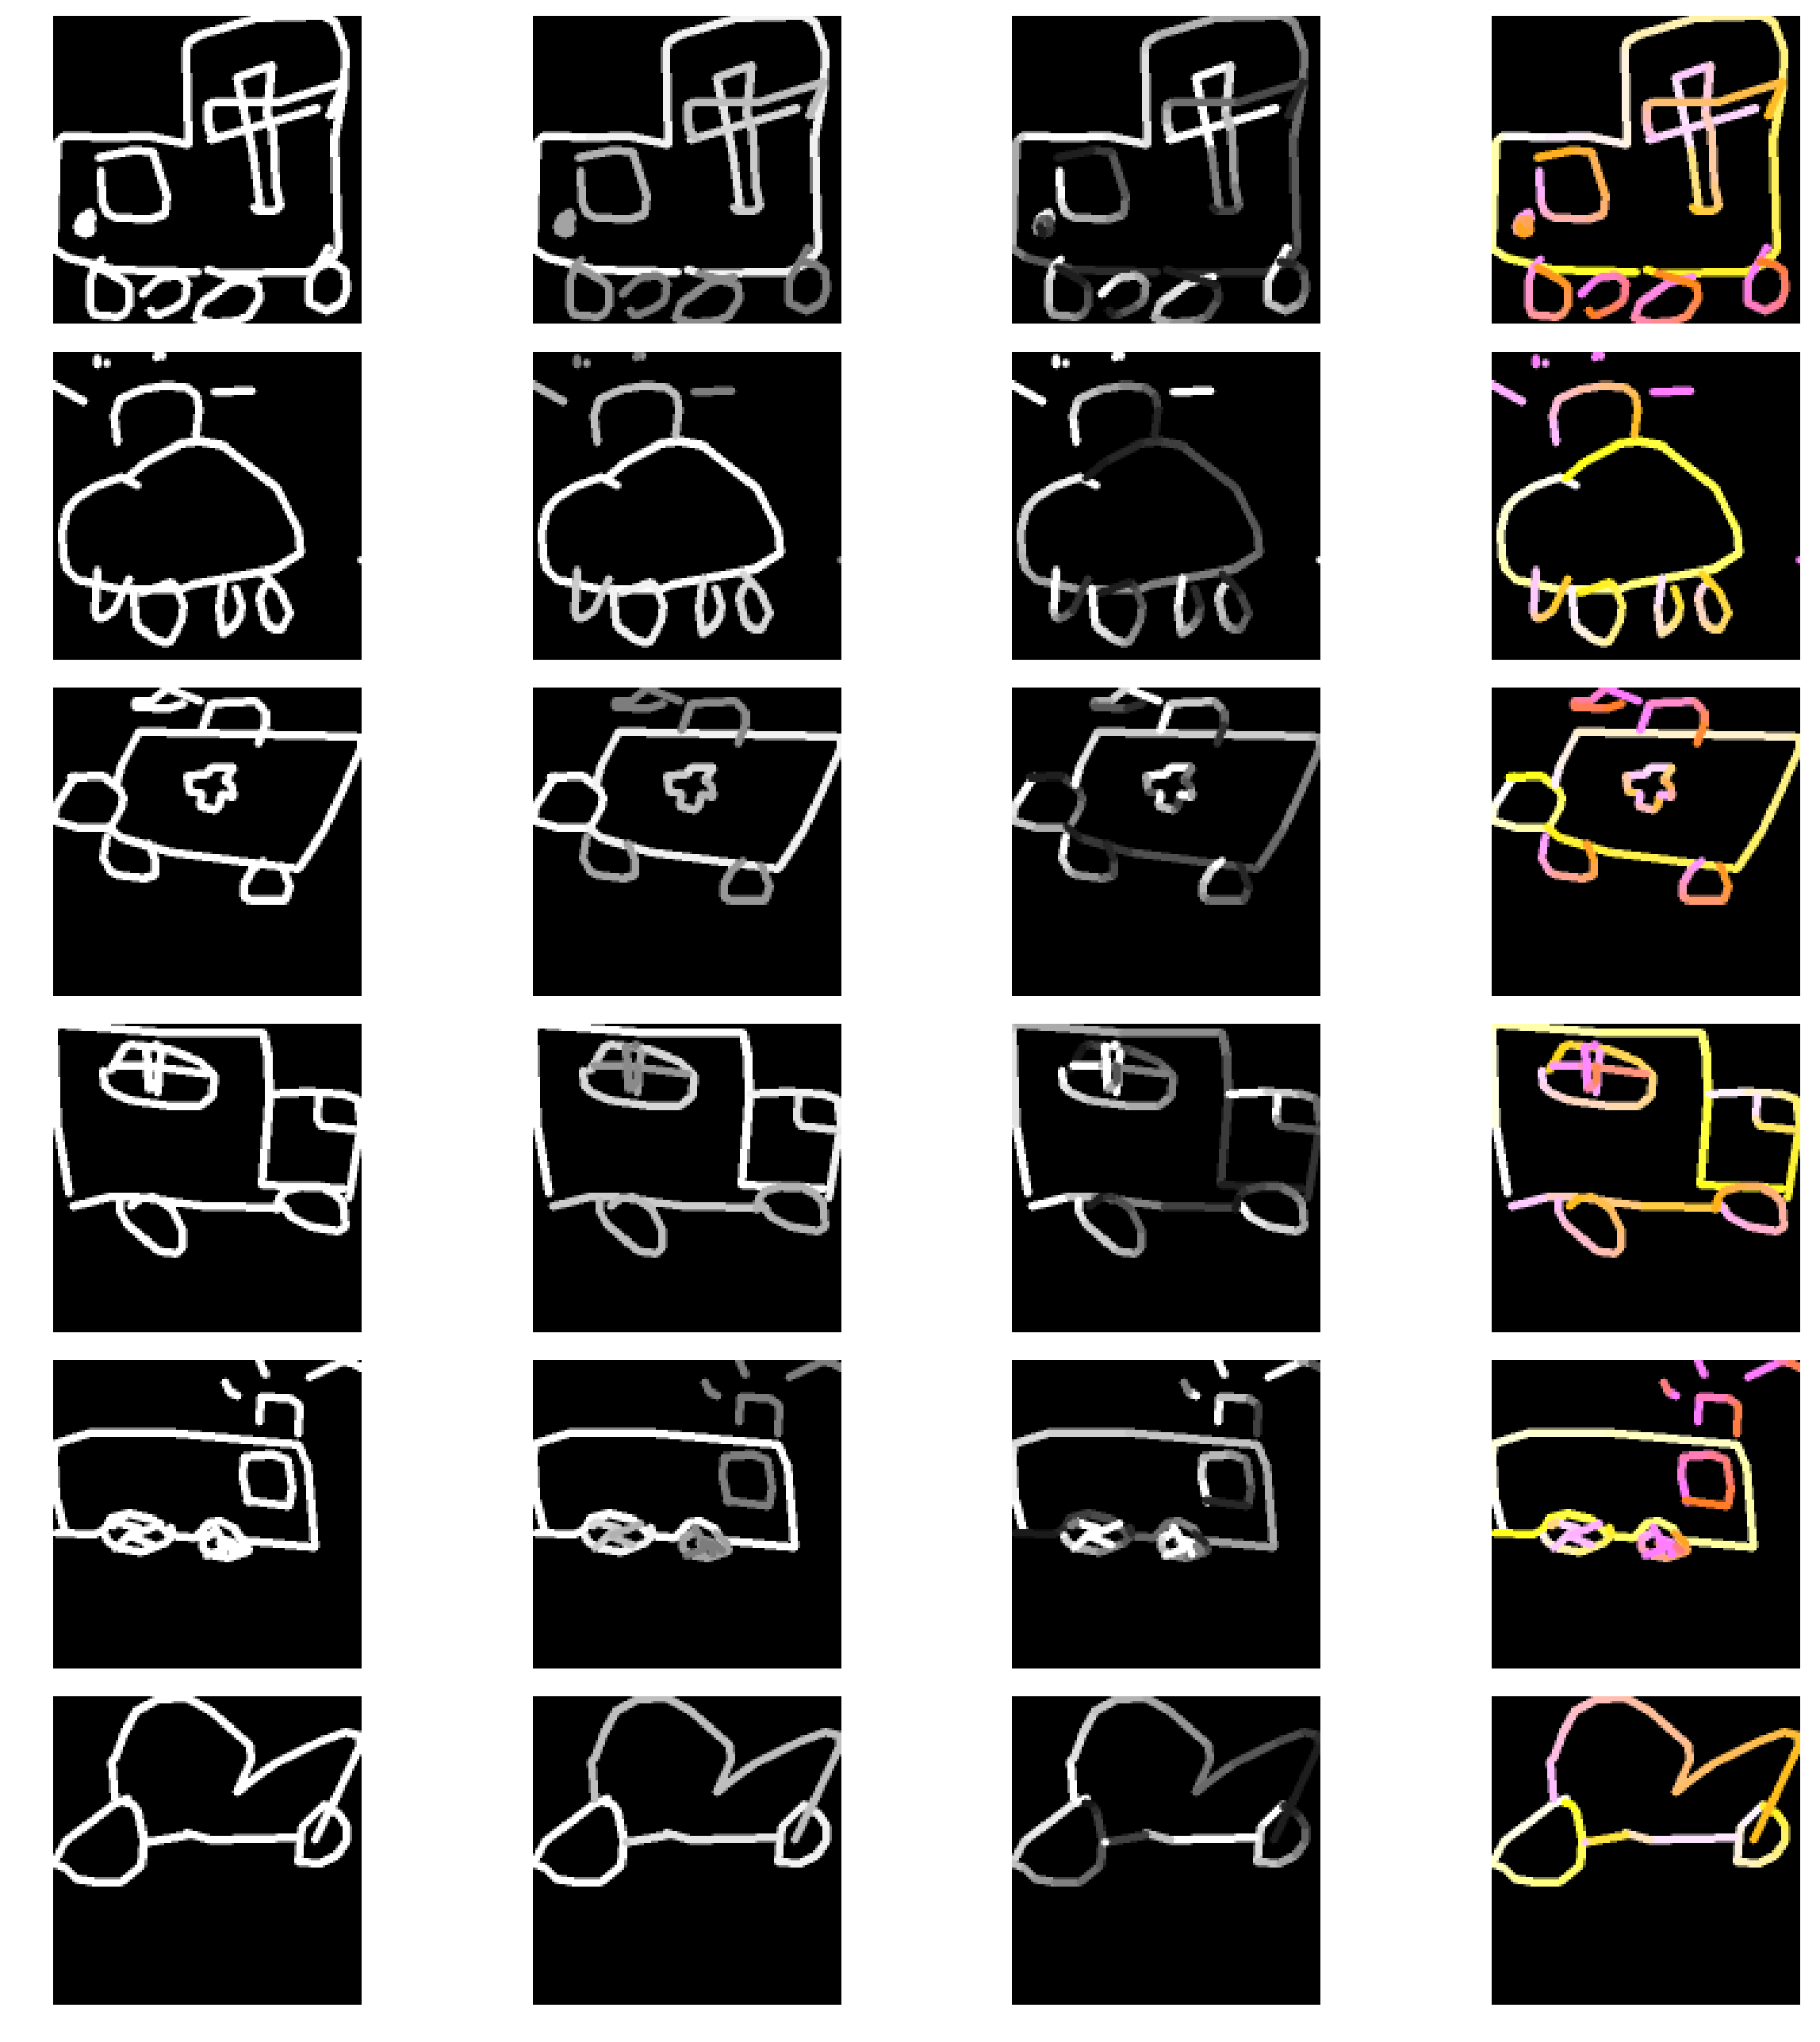

In [ ]:
single_class_df = valid_df[valid_df['y'] == 2]
single_class_gen = generator(single_class_df, size=IMG_SIZE, batchsize=BATCH_SIZE, mode='valid')
x, y = next(single_class_gen)
plot(x)

## Model

In [ ]:
reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
checkpointer = ModelCheckpoint(filepath='mobileNet_ckpt.hdf5', verbose=2, save_best_only=True)
model = load_model('/kaggle/input/mobilenet/tensorflow2/gg/1/mobileNet.hdf5', custom_objects = {'top_3_accuracy':top_3_accuracy})
opt = Adam(lr = LEARNING_RATE)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy', top_3_accuracy])
model.summary()

### 6. Training

In [ ]:
history = model.fit_generator(train_datagen,
                              steps_per_epoch=STEPS,
                              epochs=EPOCHS,
                              verbose=2,
                              validation_data=valid_datagen,
                              validation_steps=validation_steps,
                              callbacks=[checkpointer,reducer])
model.save('mobileNet.hdf5')

## Final Results

In [ ]:
result_df = pd.read_csv('/kaggle/input/quickdraw-doodle-recognition/test_simplified.csv')
result_df['drawing'] = result_df['drawing'].apply(eval)
result_datagen = test_generator(result_df, size=IMG_SIZE, batchsize=BATCH_SIZE)
result_predictions = model.predict_generator(result_datagen, math.ceil(len(result_df)/BATCH_SIZE))
cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3 = preds2catids(result_predictions)
top3cats = top3.replace(id2cat)
result_df['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
result = result_df[['key_id', 'word']]
result.to_csv('submission.csv', index=False)